## To Predict Chronic Pain Among Patients Admitted to ICU 

Chronic Pain - Any etiology of chronic pain (including fibromyalgia) requiring long-term opiod/narcotic medication to control.

**Notes** :

* PCA - look into each component's load factors (to see what variables included) and feature importance using top eigen values. Each component has it's own eigen value.
* Logistc regression - variables included
* Before any feature selection methods - we can use our knowledge/common sense (admission time/location probably shouldn't be included in the dataset). Therefore, do some manual filtering.
* Perform univariate analysis to throw out features before running algorithms.
* Draw a diagram for the pipeline

**Pipeline goes:** 

Data cleaning > Normalization > Prior knowledge to cut off some variables/Univariate Analysis to reduce dimension > PCA (selects components to be performed on other algorithms) and/or Logistic Regression (selects components on its own) > Classifier () algorithms

### Part I: Data Preprocessing

### Import packages

In [1]:
import numpy as np
from numpy import mean
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn import metrics
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, roc_auc_score, roc_curve, auc
import xgboost as xgb
from sklearn.feature_selection import RFE
from sklearn.svm import SVC
from imblearn.pipeline import Pipeline

import warnings
warnings.filterwarnings('ignore')

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

# Adjust notebook settings to widen the notebook
from IPython.core.display import display, HTML
display(HTML("<style>.container {width:85% !important;}</style>"))

### Import modules/datasets

In [ ]:
# every unique hospitalization for each patient in the database (defines HADM_ID_
admissions = pd.read_csv('data/ADMISSIONS.csv')
# every unique patient in the database (defines subject_id)
patients = pd.read_csv("data/PATIENTS.csv")
# the clinical service under which a patient is registered
services = pd.read_csv("data/SERVICES.csv")
# Diagnosis Related Groups (DRG), which are used by the hospital for billing purposes.
drgcodes = pd.read_csv("data/DRGCODES.csv")
# Deidentified notes, including nursing and physician notes, ECG reports, imaging reports, and discharge summaries.
noteevents = pd.read_csv("data/NOTEEVENTS.csv")
# Medications ordered, and not necessarily administered, for a given patient
prescriptions = pd.read_csv("data/PRESCRIPTIONS.csv")
# Ground truth dataset
phenotypes = pd.read_csv("data/GROUND_TRUTH.csv")

In [ ]:
# lowercase all strings inside of a dataframe to lowercase
admissions = admissions.apply(lambda x: x.astype(str).str.lower())
drgcodes = drgcodes.apply(lambda x: x.astype(str).str.lower())
noteevents = noteevents.apply(lambda x: x.astype(str).str.lower())
patients = patients.apply(lambda x: x.astype(str).str.lower())
services = services.apply(lambda x: x.astype(str).str.lower())
prescriptions = prescriptions.apply(lambda x: x.astype(str).str.lower())
phenotypes = phenotypes.apply(lambda x: x.astype(str).str.lower())

# lowercase columns in all dataframes
admissions.columns = admissions.columns.str.lower()
drgcodes.columns = drgcodes.columns.str.lower()
noteevents.columns = noteevents.columns.str.lower()
patients.columns = patients.columns.str.lower()
services.columns = services.columns.str.lower()
prescriptions.columns = prescriptions.columns.str.lower()
phenotypes.columns = phenotypes.columns.str.lower()

In [ ]:
# decrease the datasets by subsetting the records which ID is in phenotypes dataset
admissions_reduced = admissions[admissions['subject_id'].isin(phenotypes['subject_id'])]
drgcodes_reduced = drgcodes[drgcodes['subject_id'].isin(phenotypes['subject_id'])]
noteevents_reduced = noteevents[noteevents['subject_id'].isin(phenotypes['subject_id'])]
patients_reduced = patients[patients['subject_id'].isin(phenotypes['subject_id'])]
services_reduced = services[services['subject_id'].isin(phenotypes['subject_id'])]
prescriptions_reduced = prescriptions[prescriptions['subject_id'].isin(phenotypes['subject_id'])]

admissions_reduced = admissions_reduced.reset_index(drop=True)
drgcodes_reduced = drgcodes_reduced.reset_index(drop=True)
noteevents_reduced = noteevents_reduced.reset_index(drop=True)
patients_reduced = patients_reduced.reset_index(drop=True)
services_reduced = services_reduced.reset_index(drop=True)
prescriptions_reduced = prescriptions_reduced.reset_index(drop=True)

### Attributes Included

Link: https://mimic.mit.edu/docs/iii/tables/ 

In [ ]:
admissions.columns

**SUBJECT_ID, HADM_ID**
Each row of this table contains a unique HADM_ID, which represents a single patient’s admission to the hospital. HADM_ID ranges from 1000000 - 1999999. It is possible for this table to have duplicate SUBJECT_ID, indicating that a single patient had multiple admissions to the hospital. The ADMISSIONS table can be linked to the PATIENTS table using SUBJECT_ID.

**ADMITTIME, DISCHTIME, DEATHTIME**
ADMITTIME provides the date and time the patient was admitted to the hospital, while DISCHTIME provides the date and time the patient was discharged from the hospital. If applicable, DEATHTIME provides the time of in-hospital death for the patient. Note that DEATHTIME is only present if the patient died in-hospital, and is almost always the same as the patient’s DISCHTIME. However, there can be some discrepancies due to typographical errors.

**ADMISSION_TYPE**
ADMISSION_TYPE describes the type of the admission: ‘ELECTIVE’, ‘URGENT’, ‘NEWBORN’ or ‘EMERGENCY’. Emergency/urgent indicate unplanned medical care, and are often collapsed into a single category in studies. Elective indicates a previously planned hospital admission. Newborn indicates that the HADM_ID pertains to the patient’s birth.

**ADMISSION_LOCATION**
ADMISSION_LOCATION provides information about the previous location of the patient prior to arriving at the hospital. There are 9 possible values:

* EMERGENCY ROOM ADMIT
* TRANSFER FROM HOSP/EXTRAM
* TRANSFER FROM OTHER HEALT
* CLINIC REFERRAL/PREMATURE
* ** INFO NOT AVAILABLE **
* TRANSFER FROM SKILLED NUR
* TRSF WITHIN THIS FACILITY
* HMO REFERRAL/SICK
* PHYS REFERRAL/NORMAL DELI

The truncated text occurs in the raw data.

**INSURANCE, LANGUAGE, RELIGION, MARITAL_STATUS, ETHNICITY**
The INSURANCE, LANGUAGE, RELIGION, MARITAL_STATUS, ETHNICITY columns describe patient demographics. These columns occur in the ADMISSIONS table as they are originally sourced from the admission, discharge, and transfers (ADT) data from the hospital database. The values occasionally change between hospital admissions (HADM_ID) for a single patient (SUBJECT_ID). This is reasonable for some fields (e.g. MARITAL_STATUS, RELIGION), but less reasonable for others (e.g. ETHNICITY).

**EDREGTIME, EDOUTTIME**
Time that the patient was registered and discharged from the emergency department.

**DIAGNOSIS**
The DIAGNOSIS column provides a preliminary, free text diagnosis for the patient on hospital admission. The diagnosis is usually assigned by the admitting clinician and does not use a systematic ontology. As of MIMIC-III v1.0 there were 15,693 distinct diagnoses for 58,976 admissions. The diagnoses can be very informative (e.g. chronic kidney failure) or quite vague (e.g. weakness). Final diagnoses for a patient’s hospital stay are coded on discharge and can be found in the DIAGNOSES_ICD table. While this field can provide information about the status of a patient on hospital admission, it is not recommended to use it to stratify patients.

**HOSPITAL_EXPIRE_FLAG**
This indicates whether the patient died within the given hospitalization. 1 indicates death in the hospital, and 0 indicates survival to hospital discharge.

In [ ]:
drgcodes.columns

**SUBJECT_ID, HADM_ID**
Identifiers which specify the patient: SUBJECT_ID is unique to a patient and HADM_ID is unique to a patient hospital stay.

**DRG_TYPE**
DRG_TYPE provides the type of DRG code in the entry. There are two types of DRG codes in the database which have overlapping ranges but distinct definitions for the codes. The three types of DRG codes in the MIMIC-III database are ‘HCFA’ (Health Care Financing Administration), ‘MS’ (Medicare), and ‘APR’ (All Payers Registry).

**DRG_CODE**
DRG_CODE contains a code which represents the diagnosis billed for by the hospital.

**DESCRIPTION**
DESCRIPTION provides a human understandable summary of the meaning of the given DRG code. The description field frequently has acronyms which represent comorbidity levels (comorbid conditions or “CC”). The following table provides a definition for some of these acronyms:

Acronym	Description
* w CC/MCC	with CC or Major CC
* w MCC	with Major CC
* w CC	with CC and without Major CC
* w NonCC	with NonCC and without CC or Major CC
* w/o MCC	with CC or Non CC and without Major CC
* w/o CC/MCC	with nonCC and without CC or Major CC

Note that there are three levels of comorbidities: none, with comorbid conditions, and with major comorbid conditions. These acronyms are primarily used in HCFA/MS DRG codes.

**DRG_SEVERITY, DRG_MORTALITY, DRG_SEVERITY and DRG_MORTALITY**
provide additional granularity to DRG codes in the ‘APR’ DRG type. Severity and mortality allow for higher billing costs when a diagnosis is more severe, and vice versa.

In [ ]:
noteevents.columns

**SUBJECT_ID, HADM_ID**
Identifiers which specify the patient: SUBJECT_ID is unique to a patient and HADM_ID is unique to a patient hospital stay.

**CHARTDATE, CHARTTIME, STORETIME**
CHARTDATE records the date at which the note was charted. CHARTDATE will always have a time value of 00:00:00.

CHARTTIME records the date and time at which the note was charted. If both CHARTDATE and CHARTTIME exist, then the date portions will be identical. All records have a CHARTDATE. A subset are missing CHARTTIME. More specifically, notes with a CATEGORY value of ‘Discharge Summary’, ‘ECG’, and ‘Echo’ never have a CHARTTIME, only CHARTDATE. Other categories almost always have both CHARTTIME and CHARTDATE, but there is a small amount of missing data for CHARTTIME (usually less than 0.5% of the total number of notes for that category).

STORETIME records the date and time at which a note was saved into the system. Notes with a CATEGORY value of ‘Discharge Summary’, ‘ECG’, ‘Radiology’, and ‘Echo’ never have a STORETIME. All other notes have a STORETIME.

**CATEGORY, DESCRIPTION**
CATEGORY and DESCRIPTION define the type of note recorded. For example, a CATEGORY of ‘Discharge summary’ indicates that the note is a discharge summary, and the DESCRIPTION of ‘Report’ indicates a full report while a DESCRIPTION of ‘Addendum’ indicates an addendum (additional text to be added to the previous report).

**CGID**
CGID is the identifier for the caregiver who input the note.

**ISERROR**
A ‘1’ in the ISERROR column indicates that a physician has identified this note as an error.

**TEXT**
TEXT contains the note text.

In [ ]:
patients.columns

**SUBJECT_ID**
SUBJECT_ID is a unique identifier which specifies an individual patient. SUBJECT_ID is a candidate key for the table, so is unique for each row. Information that is consistent for the lifetime of a patient is stored in this table.

**GENDER**
GENDER is the genotypical sex of the patient.

**DOB**
DOB is the date of birth of the given patient. Patients who are older than 89 years old at any time in the database have had their date of birth shifted to obscure their age and comply with HIPAA. The shift process was as follows: the patient’s age at their first admission was determined. The date of birth was then set to exactly 300 years before their first admission.

**DOD, DOD_HOSP, DOD_SSN**
DOD is the date of death for the given patient. DOD_HOSP is the date of death as recorded in the hospital database. DOD_SSN is the date of death from the social security database. Note that DOD merged together DOD_HOSP and DOD_SSN, giving priority to DOD_HOSP if both were recorded.

**EXPIRE_FLAG**
EXPIRE_FLAG is a binary flag which indicates whether the patient died, i.e. whether DOD is null or not. These deaths include both deaths within the hospital (DOD_HOSP) and deaths identified by matching the patient to the social security master death index (DOD_SSN).

In [ ]:
services.columns

**SUBJECT_ID, HADM_ID**
Identifiers which specify the patient: SUBJECT_ID is unique to a patient and HADM_ID is unique to a patient hospital stay.

**TRANSFERTIME**
TRANSFERTIME is the time at which the patient moved from the PREV_SERVICE (if present) to the CURR_SERVICE.

**PREV_SERVICE, CURR_SERVICE**
PREV_SERVICE and CURR_SERVICE are the previous and current service that the patient resides under.


**Service	Description**

**CMED**	Cardiac Medical - for non-surgical cardiac related admissions

**CSURG**	Cardiac Surgery - for surgical cardiac admissions

**DENT**	Dental - for dental/jaw related admissions

**ENT**	Ear, nose, and throat - conditions primarily affecting these areas

**GU**	Genitourinary - reproductive organs/urinary system

**GYN**	Gynecological - female reproductive systems and breasts

**MED**	Medical - general service for internal medicine

**NB**	Newborn - infants born at the hospital

**NBB**	Newborn baby - infants born at the hospital

**NMED**	Neurologic Medical - non-surgical, relating to the brain

**NSURG**	Neurologic Surgical - surgical, relating to the brain

**OBS**	Obstetrics - conerned with childbirth and the care of women giving birth

**ORTHO**	Orthopaedic - surgical, relating to the musculoskeletal system

**OMED**	Orthopaedic medicine - non-surgical, relating to musculoskeletal system

**PSURG**	Plastic - restortation/reconstruction of the human body (including cosmetic or aesthetic)

**PSYCH**	Psychiatric - mental disorders relating to mood, behaviour, cognition, or perceptions

**SURG**	Surgical - general surgical service not classified elsewhere

**TRAUM**	Trauma - injury or damage caused by physical harm from an external source

**TSURG**	Thoracic Surgical - surgery on the thorax, located between the neck and the abdomen

**VSURG**	Vascular Surgical - surgery relating to the circulatory system

In [ ]:
prescriptions.columns

**SUBJECT_ID, HADM_ID, ICUSTAY_ID**
Identifiers which specify the patient: SUBJECT_ID is unique to a patient, HADM_ID is unique to a patient hospital stay and ICUSTAY_ID is unique to a patient ICU stay.

**STARTDATE, ENDDATE**
STARTDATE and ENDDATE specify the date period for which the prescription was valid.

**DRUG_TYPE**
DRUG_TYPE provides the type of drug prescribed.

**DRUG, DRUG_NAME_POE, DRUG_NAME_GENERIC**
These columns are various representations of the drug prescribed to the patient.

**FORMULARY_DRUG_CD, GSN, NDC**
These columns provide a representation of the drug in various coding systems. GSN is the Generic Sequence Number. NDC is the National Drug Code

**PROD_STRENGTH
DOSE_VAL_RX, DOSE_UNIT_RX
FORM_VAL_DISP, FORM_UNIT_DISP**

**ROUTE**
The route prescribed for the drug.

### Functions

In [ ]:
# function to get unique values
def unique(list1):
    x = np.array(list1)
    print(np.unique(x))

### Clean dataset: phenotypes

In [ ]:
# Only keep the interested outcome feature
phenotypes_reduced = phenotypes[['hadm_id','subject_id','chronic.pain.fibromyalgia']]
# Drop duplicated records by subject_id and hadm_id
phenotypes_reduced = phenotypes_reduced.drop_duplicates(subset=['subject_id','hadm_id'], ignore_index = True)

In [ ]:
# Size of phenotypes_reduced
phenotypes_reduced.shape

In [ ]:
phenotypes_reduced.head()

In [ ]:
phenotypes['chronic.pain.fibromyalgia'].value_counts()

### Clean dataset: admissions

#### Regarding diagnosis feature from admission: 

15,693 distinct diagnoses for 58,976 admissions. The diagnoses can be very informative (e.g. chronic kidney failure) or quite vague (e.g. weakness). Final diagnoses for a patient’s hospital stay are coded on discharge and can be found in the DIAGNOSES_ICD table. While this field can provide information about the status of a patient on hospital admission, it is not recommended to use it to stratify patients.


In [ ]:
# Size of admissions_reduced
admissions_reduced.shape

In [ ]:
# Since the dates and times from the database are deidentified -- create new features to get the time difference
admissions_reduced['edouttime'] = pd.to_datetime(admissions_reduced['edouttime'])
admissions_reduced['edregtime'] = pd.to_datetime(admissions_reduced['edregtime'])
admissions_reduced['length_ed'] = (admissions_reduced['edouttime'] - admissions_reduced['edregtime']).dt.days
admissions_reduced['dischtime'] = pd.to_datetime(admissions_reduced['dischtime'])
admissions_reduced['admittime'] = pd.to_datetime(admissions_reduced['admittime'])
admissions_reduced['length_admit'] = (admissions_reduced['dischtime'] - admissions_reduced['admittime']).dt.days
# Drop time-related features used to create new features
admissions_reduced = admissions_reduced.drop(['edregtime', 'edouttime', 'dischtime', 'admittime'], axis = 1)

In [ ]:
# Create aggregate, dummy, and new variables for admission df to create one row per id
just_dummies = pd.get_dummies(admissions_reduced['admission_type'], prefix='admission_type', drop_first=True)
admissions_reduced = pd.concat([admissions_reduced, just_dummies], axis=1)
# Create dummy variables for admission location
just_dummies = pd.get_dummies(admissions_reduced['admission_location'], prefix='admission_loc', drop_first=True)
admissions_reduced = pd.concat([admissions_reduced, just_dummies], axis=1)
# Create dummy variables for discharge location
just_dummies = pd.get_dummies(admissions_reduced['discharge_location'], prefix='discharge_loc', drop_first=True)
admissions_reduced = pd.concat([admissions_reduced, just_dummies], axis=1)
# Create dummy variables for insurance
just_dummies = pd.get_dummies(admissions_reduced['insurance'], prefix='insurance', drop_first=True)
admissions_reduced = pd.concat([admissions_reduced, just_dummies], axis=1)
# Create dummy variables for religions
just_dummies = pd.get_dummies(admissions_reduced['religion'], prefix='religion', drop_first=True)
admissions_reduced = pd.concat([admissions_reduced, just_dummies], axis=1)
# Create dummy variables for language
just_dummies = pd.get_dummies(admissions_reduced['language'], prefix='language', drop_first=True)
admissions_reduced = pd.concat([admissions_reduced, just_dummies], axis=1)
# Create dummy variables for marital_status
just_dummies = pd.get_dummies(admissions_reduced['marital_status'], prefix='marital_status', drop_first=True)
admissions_reduced = pd.concat([admissions_reduced, just_dummies], axis=1)
# Create dummy variables for ethnicity
just_dummies = pd.get_dummies(admissions_reduced['ethnicity'], prefix='ethnicity', drop_first=True)
admissions_reduced = pd.concat([admissions_reduced, just_dummies], axis=1)

In [ ]:
# Remove features used to dummy variables
admissions_reduced = admissions_reduced.drop(['row_id', 'deathtime', 'diagnosis', 'religion', 'language','marital_status', 'ethnicity', 'insurance', 'admission_location', 'discharge_location', 'admission_type'], axis = 1)

In [ ]:
admissions_reduced["hospital_expire_flag"] = admissions_reduced.hospital_expire_flag.astype(float)
admissions_reduced["has_chartevents_data"] = admissions_reduced.has_chartevents_data.astype(float)

In [ ]:
# Size of cleaned admissions_reduced dataset
admissions_reduced.shape

### Clean dataset: patients

In [ ]:
# Size of patients_reduced dataset
patients_reduced.shape

In [ ]:
# Create numerical code for string variables in the gender feature
patients_reduced.gender[patients_reduced.gender == 'm'] = 1
patients_reduced.gender[patients_reduced.gender == 'f'] = 0

In [ ]:
# Removing PIH features that had been deidentified
patients_reduced = patients_reduced.drop(['row_id', 'dob', 'dod', 'dod_hosp', 'dod_ssn'], axis = 1)

In [ ]:
# Final features left for patients_reduced dataset
patients_reduced.head(2)

### Cleaning dataset:  drgcodes

In [ ]:
drgcodes_reduced.shape

In [ ]:
drgcodes_reduced.head(3)

In [ ]:
# Create dummy variables for drg_code
just_dummies = pd.get_dummies(drgcodes_reduced['drg_code'], prefix='drg_code', drop_first=True)
drgcodes_reduced = pd.concat([drgcodes_reduced, just_dummies], axis=1)

# Create dummy variables for drg_code
just_dummies = pd.get_dummies(drgcodes_reduced['drg_type'], prefix='drg_type', drop_first=True)
drgcodes_reduced = pd.concat([drgcodes_reduced, just_dummies], axis=1)

In [ ]:
# Transform object to numerical features
drgcodes_reduced['drg_mortality'] = pd.to_numeric(drgcodes_reduced.drg_mortality, errors='coerce').fillna(0, downcast='infer').astype('Int32')
drgcodes_reduced['drg_severity'] = pd.to_numeric(drgcodes_reduced.drg_severity, errors='coerce').fillna(0, downcast='infer').astype('Int32')

In [ ]:
# In order to have one record for each unique combination of subject_id and hadm_id, mean of the drg_mortality and drg_severity
# are calculated
drgcodes_reduced['avg_drg_mortality'] = drgcodes_reduced.groupby(['subject_id', 'hadm_id']).drg_mortality.transform('mean')
drgcodes_reduced['avg_drg_severity'] = drgcodes_reduced.groupby(['subject_id', 'hadm_id']).drg_severity.transform('mean')

In [ ]:
drgcodes_reduced['avg_drg_mortality'] = drgcodes_reduced.avg_drg_mortality.astype(float)
drgcodes_reduced['avg_drg_severity'] = drgcodes_reduced.avg_drg_severity.astype(float)

In [ ]:
# Drop duplicates by comparing subject_id and hadm_id
drgcodes_reduced = drgcodes_reduced.drop_duplicates(subset=['subject_id','hadm_id'], ignore_index = True)

In [ ]:
drgcodes_reduced = drgcodes_reduced.drop(['row_id', 'description', 'drg_code', 'drg_type', 'drg_severity', 'drg_mortality' ], axis = 1)

In [ ]:
# Final size of the drgcodes_reduced
drgcodes_reduced.shape

In [ ]:
drgcodes_reduced.columns

### Merge Datasets

In [ ]:
phenotypes_reduced.shape

In [ ]:
main = pd.merge(admissions_reduced, phenotypes_reduced,
                how ='right',
                on = ['subject_id', 'hadm_id'])

main = pd.merge(main, patients_reduced,
                how ='left',
                on = ['subject_id'])

main = pd.merge(main, drgcodes_reduced,
                how ='left',
                on = ['subject_id', 'hadm_id'])

In [ ]:
main["expire_flag"] = main.expire_flag.astype(float)
main['gender'] = main.gender.astype(int)

In [ ]:
main.shape # final dataset (813, 742)

### Missingness of the final merged datasets

In [ ]:
main.isnull().mean() # length_ed had ~30% missingness

In [ ]:
main['length_ed'] = main['length_ed'].fillna(0) # not entirely sure about this 

In [ ]:
cols = list(main.columns.values)
cols.pop(cols.index('chronic.pain.fibromyalgia'))
main = main[cols+['chronic.pain.fibromyalgia']]

In [ ]:
main["hospital_expire_flag"] = main.hospital_expire_flag.astype(float)
main["has_chartevents_data"] = main.has_chartevents_data.astype(float)
main["expire_flag"] = main.expire_flag.astype(float)
main['gender'] = main.gender.astype(int)
main['avg_drg_mortality'] = main.avg_drg_mortality.astype(float)
main['avg_drg_severity'] = main.avg_drg_severity.astype(float)
main['chronic.pain.fibromyalgia'] = main['chronic.pain.fibromyalgia'].astype(int)

In [9]:
main.drop(['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1.1', 'subject_id', 'hadm_id'], axis = 1, inplace=True)

In [10]:
main.to_csv('data/main.csv')

In [11]:
# Load cleaned and merged dataset
main = pd.read_csv("data/main.csv")

In [12]:
main.shape # (813, 731)

(813, 731)

In [14]:
main.drop(['Unnamed: 0'], axis = 1, inplace=True)

In [13]:
main.head(2)

,Unnamed: 0,hospital_expire_flag,has_chartevents_data,length_ed,length_admit,admission_type_emergency,admission_type_urgent,admission_loc_emergency room admit,admission_loc_phys referral/normal deli,admission_loc_transfer from hosp/extram,admission_loc_transfer from other healt,admission_loc_transfer from skilled nur,discharge_loc_disc-tran cancer/chldrn h,discharge_loc_disch-tran to psych hosp,discharge_loc_home,discharge_loc_home health care,discharge_loc_home with home iv providr,discharge_loc_hospice-home,discharge_loc_hospice-medical facility,discharge_loc_icf,discharge_loc_left against medical advi,discharge_loc_long term care hospital,discharge_loc_other facility,discharge_loc_rehab/distinct part hosp,discharge_loc_short term hospital,discharge_loc_snf,insurance_medicaid,insurance_medicare,insurance_private,insurance_self pay,religion_buddhist,religion_catholic,religion_christian scientist,religion_episcopalian,religion_greek orthodox,religion_hebrew,religion_jehovah's witness,religion_jewish,religion_muslim,religion_nan,religion_not specified,religion_other,religion_protestant quaker,religion_romanian east. orth,religion_unitarian-universalist,religion_unobtainable,language_*hun,language_*man,language_arab,language_camb,language_cant,language_cape,language_engl,language_fren,language_gree,language_hait,language_ital,language_nan,language_pers,language_port,language_ptun,language_russ,language_span,language_urdu,marital_status_life partner,marital_status_married,marital_status_nan,marital_status_separated,marital_status_single,marital_status_unknown (default),marital_status_widowed,ethnicity_asian - asian indian,ethnicity_asian - chinese,ethnicity_black/african,ethnicity_black/african american,ethnicity_black/cape verdean,ethnicity_black/haitian,ethnicity_hispanic or latino,ethnicity_hispanic/latino - guatemalan,ethnicity_hispanic/latino - puerto rican,ethnicity_other,ethnicity_patient declined to answer,ethnicity_portuguese,ethnicity_unable to obtain,ethnicity_unknown/not specified,ethnicity_white,ethnicity_white - brazilian,ethnicity_white - eastern european,ethnicity_white - russian,gender,expire_flag,drg_code_10,drg_code_100,drg_code_101,drg_code_104,drg_code_105,drg_code_106,drg_code_107,drg_code_108,drg_code_109,drg_code_11,drg_code_110,drg_code_1103,drg_code_1104,drg_code_111,drg_code_113,drg_code_114,drg_code_1144,drg_code_115,drg_code_1152,drg_code_1153,drg_code_116,drg_code_117,drg_code_12,drg_code_120,drg_code_1201,drg_code_1202,drg_code_1203,drg_code_1204,drg_code_121,drg_code_1212,drg_code_1213,drg_code_1214,drg_code_122,drg_code_123,drg_code_124,drg_code_127,drg_code_129,drg_code_130,drg_code_1303,drg_code_1304,drg_code_131,drg_code_1332,drg_code_1333,drg_code_1334,drg_code_134,drg_code_1342,drg_code_1343,drg_code_1344,drg_code_1362,drg_code_1363,drg_code_1364,drg_code_1372,drg_code_1373,drg_code_1374,drg_code_138,drg_code_1393,drg_code_1394,drg_code_14,drg_code_1402,drg_code_1403,drg_code_1404,drg_code_141,drg_code_1413,drg_code_1422,drg_code_1431,drg_code_1432,drg_code_1433,drg_code_1434,drg_code_144,drg_code_1443,drg_code_1444,drg_code_146,drg_code_148,drg_code_150,drg_code_152,drg_code_154,drg_code_159,drg_code_161,drg_code_1613,drg_code_1614,drg_code_1623,drg_code_1624,drg_code_163,drg_code_1631,drg_code_1632,drg_code_1633,drg_code_1634,drg_code_164,drg_code_1652,drg_code_1653,drg_code_1654,drg_code_166,drg_code_1662,drg_code_1663,drg_code_1664,drg_code_167,drg_code_1671,drg_code_1673,drg_code_168,drg_code_1693,drg_code_1694,drg_code_170,drg_code_1703,drg_code_1712,drg_code_1713,drg_code_1714,drg_code_172,drg_code_1731,drg_code_1732,drg_code_1733,drg_code_1734,drg_code_174,drg_code_1741,drg_code_1742,drg_code_1743,drg_code_1744,drg_code_175,drg_code_1752,drg_code_1753,drg_code_1754,drg_code_176,drg_code_177,drg_code_178,drg_code_18,drg_code_180,drg_code_1802,drg_code_1803,drg_code_1804,drg_code_182,drg_code_185,drg_code_186,drg_code_187,drg_code_188,drg_code_189,drg_code_190,drg_code_1901,drg_code_190

### Restructuring -- Move the outcome variable to be the last column in the dataset

#### Set X as features and y as the outcome

In [15]:
main.head(2)

,hospital_expire_flag,has_chartevents_data,length_ed,length_admit,admission_type_emergency,admission_type_urgent,admission_loc_emergency room admit,admission_loc_phys referral/normal deli,admission_loc_transfer from hosp/extram,admission_loc_transfer from other healt,admission_loc_transfer from skilled nur,discharge_loc_disc-tran cancer/chldrn h,discharge_loc_disch-tran to psych hosp,discharge_loc_home,discharge_loc_home health care,discharge_loc_home with home iv providr,discharge_loc_hospice-home,discharge_loc_hospice-medical facility,discharge_loc_icf,discharge_loc_left against medical advi,discharge_loc_long term care hospital,discharge_loc_other facility,discharge_loc_rehab/distinct part hosp,discharge_loc_short term hospital,discharge_loc_snf,insurance_medicaid,insurance_medicare,insurance_private,insurance_self pay,religion_buddhist,religion_catholic,religion_christian scientist,religion_episcopalian,religion_greek orthodox,religion_hebrew,religion_jehovah's witness,religion_jewish,religion_muslim,religion_nan,religion_not specified,religion_other,religion_protestant quaker,religion_romanian east. orth,religion_unitarian-universalist,religion_unobtainable,language_*hun,language_*man,language_arab,language_camb,language_cant,language_cape,language_engl,language_fren,language_gree,language_hait,language_ital,language_nan,language_pers,language_port,language_ptun,language_russ,language_span,language_urdu,marital_status_life partner,marital_status_married,marital_status_nan,marital_status_separated,marital_status_single,marital_status_unknown (default),marital_status_widowed,ethnicity_asian - asian indian,ethnicity_asian - chinese,ethnicity_black/african,ethnicity_black/african american,ethnicity_black/cape verdean,ethnicity_black/haitian,ethnicity_hispanic or latino,ethnicity_hispanic/latino - guatemalan,ethnicity_hispanic/latino - puerto rican,ethnicity_other,ethnicity_patient declined to answer,ethnicity_portuguese,ethnicity_unable to obtain,ethnicity_unknown/not specified,ethnicity_white,ethnicity_white - brazilian,ethnicity_white - eastern european,ethnicity_white - russian,gender,expire_flag,drg_code_10,drg_code_100,drg_code_101,drg_code_104,drg_code_105,drg_code_106,drg_code_107,drg_code_108,drg_code_109,drg_code_11,drg_code_110,drg_code_1103,drg_code_1104,drg_code_111,drg_code_113,drg_code_114,drg_code_1144,drg_code_115,drg_code_1152,drg_code_1153,drg_code_116,drg_code_117,drg_code_12,drg_code_120,drg_code_1201,drg_code_1202,drg_code_1203,drg_code_1204,drg_code_121,drg_code_1212,drg_code_1213,drg_code_1214,drg_code_122,drg_code_123,drg_code_124,drg_code_127,drg_code_129,drg_code_130,drg_code_1303,drg_code_1304,drg_code_131,drg_code_1332,drg_code_1333,drg_code_1334,drg_code_134,drg_code_1342,drg_code_1343,drg_code_1344,drg_code_1362,drg_code_1363,drg_code_1364,drg_code_1372,drg_code_1373,drg_code_1374,drg_code_138,drg_code_1393,drg_code_1394,drg_code_14,drg_code_1402,drg_code_1403,drg_code_1404,drg_code_141,drg_code_1413,drg_code_1422,drg_code_1431,drg_code_1432,drg_code_1433,drg_code_1434,drg_code_144,drg_code_1443,drg_code_1444,drg_code_146,drg_code_148,drg_code_150,drg_code_152,drg_code_154,drg_code_159,drg_code_161,drg_code_1613,drg_code_1614,drg_code_1623,drg_code_1624,drg_code_163,drg_code_1631,drg_code_1632,drg_code_1633,drg_code_1634,drg_code_164,drg_code_1652,drg_code_1653,drg_code_1654,drg_code_166,drg_code_1662,drg_code_1663,drg_code_1664,drg_code_167,drg_code_1671,drg_code_1673,drg_code_168,drg_code_1693,drg_code_1694,drg_code_170,drg_code_1703,drg_code_1712,drg_code_1713,drg_code_1714,drg_code_172,drg_code_1731,drg_code_1732,drg_code_1733,drg_code_1734,drg_code_174,drg_code_1741,drg_code_1742,drg_code_1743,drg_code_1744,drg_code_175,drg_code_1752,drg_code_1753,drg_code_1754,drg_code_176,drg_code_177,drg_code_178,drg_code_18,drg_code_180,drg_code_1802,drg_code_1803,drg_code_1804,drg_code_182,drg_code_185,drg_code_186,drg_code_187,drg_code_188,drg_code_189,drg_code_190,drg_code_1901,drg_code_1903,drg_code_

In [ ]:
df = main.drop(['Unnamed: 0','subject_id', 'hadm_id'], axis = 1)

## Feature Scaling - Standardization vs. Normalization

Feature scaling is essential for machine learning algorithms that calculate distances between data. Therefore, the range of all features should be normalized so that each feature contributes approximately proportionately to the final distance.

* Normalization is recommended when you have a normally distributed observations.
* Standardization works all the time. (recommended)
* We need to perform Feature Scaling when we are dealing with Gradient Descent Based algorithms (Linear and Logistic Regression, Neural Network) and Distance-based algorithms (KNN, K-means, SVM) as these are very sensitive to the range of the data points.

* It is a good practice to fit the scaler on the training data and then use it to transform the testing data. This would avoid any data leakage during the model testing process. Also, the scaling of target values is generally not required.
* Only apply standardization to numerical columns and not the other One-Hot Encoded features. Standardizing the One-Hot encoded features would mean assigning a distribution to categorical features. You don’t want to do that! While it is fine to apply normalization to all kinds of columns including One-Hot Encorded features because One-Hot encoded features are already in the range between 0 to 1. So, normalization would not affect their value.

### Normalization

In [22]:
df = main.copy()

In [26]:
y = df['chronic.pain.fibromyalgia']
X = df.drop(['chronic.pain.fibromyalgia'], axis=1)
print('y shape:', y.shape)
print('X shape:', X.shape)

y shape: (813,)
X shape: (813, 729)


In [27]:
y.value_counts() # imbalanced classes

0    702
1    111
Name: chronic.pain.fibromyalgia, dtype: int64

In [28]:
# Normalization 
from sklearn.preprocessing import MinMaxScaler

# fit scaler on training data
norm = MinMaxScaler().fit(X)

# transform training data
# X_train_norm = norm.transform(X_train)

# # transofrm testing data
# X_test_norm = norm.transform(X_test)

In [ ]:
# # Focusing on normalized dataset for now. 
# # Standardization with sklearn
# from sklearn.preprocessing import StandardScaler

# # copy of datasets
# X_train_stand = X_train.copy()
# X_test_stand = X_test.copy()

# # numerical features
# num_cols = ['hospital_expire_flag', 'avg_drg_mortality']

# # apply standardization on numerical features
# for i in num_cols:
#     scale = StandardScaler().fit(X_train_stand[[i]])
#     X_train_stand[i] = scale.transform(X_train_stand[[i]])
#     X_test_stand[i] = scale.transform(X_test_stand[[i]])

## Feature selection

Three benefits of performing feature selection before modeling your data are:

Reduces Overfitting: Less redundant data means less opportunity to make decisions based on noise.
Improves Accuracy: Less misleading data means modeling accuracy improves.
Reduces Training Time: Less data means that algorithms train faster.

### Method 1: Univariate Analysis

### Method 2: Recursive feature elimination

In [34]:
X

['hospital_expire_flag',
 'has_chartevents_data',
 'length_ed',
 'length_admit',
 'admission_type_emergency',
 'admission_type_urgent',
 'admission_loc_emergency room admit',
 'admission_loc_phys referral/normal deli',
 'admission_loc_transfer from hosp/extram',
 'admission_loc_transfer from other healt',
 'admission_loc_transfer from skilled nur',
 'discharge_loc_disc-tran cancer/chldrn h',
 'discharge_loc_disch-tran to psych hosp',
 'discharge_loc_home',
 'discharge_loc_home health care',
 'discharge_loc_home with home iv providr',
 'discharge_loc_hospice-home',
 'discharge_loc_hospice-medical facility',
 'discharge_loc_icf',
 'discharge_loc_left against medical advi',
 'discharge_loc_long term care hospital',
 'discharge_loc_other facility',
 'discharge_loc_rehab/distinct part hosp',
 'discharge_loc_short term hospital',
 'discharge_loc_snf',
 'insurance_medicaid',
 'insurance_medicare',
 'insurance_private',
 'insurance_self pay',
 'religion_buddhist',
 'religion_catholic',
 'relig

In [31]:
from sklearn.feature_selection import RFE

df_vars = X.columns.values.tolist()
y=['chronic.pain.fibromyalgia']
X=[i for i in df_vars if i not in y]

logreg = LogisticRegression()
rfe_100 = RFE(logreg, 100)
rfe_100 = rfe_100.fit(X, y)

def column_index(df, query_cols):
    cols = df.columns.values
    sidx = np.argsort(cols)
    return sidx[np.searchsorted(cols, query_cols, sorter = sidx)]

feature_index = []
features = []
column_index(X, X.columns.values)

for num, i in enumerate(rfe_100.get_support(), start=0):
    if i == True:
        feature_index.append(str(num))

for num, i in enumerate(X.columns.values, start=0):
    if str(num) in feature_index:
        features.append(X.columns.values[num])

print("Features Selected: {}\n".format(len(feature_index)))
print("Features Indexes: \n{}\n".format(feature_index))
print("Feature Names: \n{}".format(features))

ValueError: Expected 2D array, got 1D array instead:
array=['hospital_expire_flag' 'has_chartevents_data' 'length_ed' 'length_admit'
 'admission_type_emergency' 'admission_type_urgent'
 'admission_loc_emergency room admit'
 'admission_loc_phys referral/normal deli'
 'admission_loc_transfer from hosp/extram'
 'admission_loc_transfer from other healt'
 'admission_loc_transfer from skilled nur'
 'discharge_loc_disc-tran cancer/chldrn h'
 'discharge_loc_disch-tran to psych hosp' 'discharge_loc_home'
 'discharge_loc_home health care'
 'discharge_loc_home with home iv providr' 'discharge_loc_hospice-home'
 'discharge_loc_hospice-medical facility' 'discharge_loc_icf'
 'discharge_loc_left against medical advi'
 'discharge_loc_long term care hospital' 'discharge_loc_other facility'
 'discharge_loc_rehab/distinct part hosp'
 'discharge_loc_short term hospital' 'discharge_loc_snf'
 'insurance_medicaid' 'insurance_medicare' 'insurance_private'
 'insurance_self pay' 'religion_buddhist' 'religion_catholic'
 'religion_christian scientist' 'religion_episcopalian'
 'religion_greek orthodox' 'religion_hebrew' "religion_jehovah's witness"
 'religion_jewish' 'religion_muslim' 'religion_nan'
 'religion_not specified' 'religion_other' 'religion_protestant quaker'
 'religion_romanian east. orth' 'religion_unitarian-universalist'
 'religion_unobtainable' 'language_*hun' 'language_*man' 'language_arab'
 'language_camb' 'language_cant' 'language_cape' 'language_engl'
 'language_fren' 'language_gree' 'language_hait' 'language_ital'
 'language_nan' 'language_pers' 'language_port' 'language_ptun'
 'language_russ' 'language_span' 'language_urdu'
 'marital_status_life partner' 'marital_status_married'
 'marital_status_nan' 'marital_status_separated' 'marital_status_single'
 'marital_status_unknown (default)' 'marital_status_widowed'
 'ethnicity_asian - asian indian' 'ethnicity_asian - chinese'
 'ethnicity_black/african' 'ethnicity_black/african american'
 'ethnicity_black/cape verdean' 'ethnicity_black/haitian'
 'ethnicity_hispanic or latino' 'ethnicity_hispanic/latino - guatemalan'
 'ethnicity_hispanic/latino - puerto rican' 'ethnicity_other'
 'ethnicity_patient declined to answer' 'ethnicity_portuguese'
 'ethnicity_unable to obtain' 'ethnicity_unknown/not specified'
 'ethnicity_white' 'ethnicity_white - brazilian'
 'ethnicity_white - eastern european' 'ethnicity_white - russian' 'gender'
 'expire_flag' 'drg_code_10' 'drg_code_100' 'drg_code_101' 'drg_code_104'
 'drg_code_105' 'drg_code_106' 'drg_code_107' 'drg_code_108'
 'drg_code_109' 'drg_code_11' 'drg_code_110' 'drg_code_1103'
 'drg_code_1104' 'drg_code_111' 'drg_code_113' 'drg_code_114'
 'drg_code_1144' 'drg_code_115' 'drg_code_1152' 'drg_code_1153'
 'drg_code_116' 'drg_code_117' 'drg_code_12' 'drg_code_120'
 'drg_code_1201' 'drg_code_1202' 'drg_code_1203' 'drg_code_1204'
 'drg_code_121' 'drg_code_1212' 'drg_code_1213' 'drg_code_1214'
 'drg_code_122' 'drg_code_123' 'drg_code_124' 'drg_code_127'
 'drg_code_129' 'drg_code_130' 'drg_code_1303' 'drg_code_1304'
 'drg_code_131' 'drg_code_1332' 'drg_code_1333' 'drg_code_1334'
 'drg_code_134' 'drg_code_1342' 'drg_code_1343' 'drg_code_1344'
 'drg_code_1362' 'drg_code_1363' 'drg_code_1364' 'drg_code_1372'
 'drg_code_1373' 'drg_code_1374' 'drg_code_138' 'drg_code_1393'
 'drg_code_1394' 'drg_code_14' 'drg_code_1402' 'drg_code_1403'
 'drg_code_1404' 'drg_code_141' 'drg_code_1413' 'drg_code_1422'
 'drg_code_1431' 'drg_code_1432' 'drg_code_1433' 'drg_code_1434'
 'drg_code_144' 'drg_code_1443' 'drg_code_1444' 'drg_code_146'
 'drg_code_148' 'drg_code_150' 'drg_code_152' 'drg_code_154'
 'drg_code_159' 'drg_code_161' 'drg_code_1613' 'drg_code_1614'
 'drg_code_1623' 'drg_code_1624' 'drg_code_163' 'drg_code_1631'
 'drg_code_1632' 'drg_code_1633' 'drg_code_1634' 'drg_code_164'
 'drg_code_1652' 'drg_code_1653' 'drg_code_1654' 'drg_code_166'
 'drg_code_1662' 'drg_code_1663' 'drg_code_1664' 'drg_code_167'
 'drg_code_1671' 'drg_code_1673' 'drg_code_168' 'drg_code_1693'
 'drg_code_1694' 'drg_code_170' 'drg_code_1703' 'drg_code_1712'
 'drg_code_1713' 'drg_code_1714' 'drg_code_172' 'drg_code_1731'
 'drg_code_1732' 'drg_code_1733' 'drg_code_1734' 'drg_code_174'
 'drg_code_1741' 'drg_code_1742' 'drg_code_1743' 'drg_code_1744'
 'drg_code_175' 'drg_code_1752' 'drg_code_1753' 'drg_code_1754'
 'drg_code_176' 'drg_code_177' 'drg_code_178' 'drg_code_18' 'drg_code_180'
 'drg_code_1802' 'drg_code_1803' 'drg_code_1804' 'drg_code_182'
 'drg_code_185' 'drg_code_186' 'drg_code_187' 'drg_code_188'
 'drg_code_189' 'drg_code_190' 'drg_code_1901' 'drg_code_1903'
 'drg_code_1904' 'drg_code_191' 'drg_code_1913' 'drg_code_1914'
 'drg_code_1923' 'drg_code_193' 'drg_code_194' 'drg_code_1941'
 'drg_code_1942' 'drg_code_1943' 'drg_code_1944' 'drg_code_195'
 'drg_code_1964' 'drg_code_197' 'drg_code_1972' 'drg_code_1973'
 'drg_code_1974' 'drg_code_1993' 'drg_code_1994' 'drg_code_2'
 'drg_code_20' 'drg_code_200' 'drg_code_201' 'drg_code_2012'
 'drg_code_2013' 'drg_code_2014' 'drg_code_202' 'drg_code_203'
 'drg_code_2034' 'drg_code_204' 'drg_code_205' 'drg_code_206'
 'drg_code_2063' 'drg_code_2064' 'drg_code_207' 'drg_code_2071'
 'drg_code_2072' 'drg_code_2073' 'drg_code_2074' 'drg_code_208'
 'drg_code_209' 'drg_code_21' 'drg_code_210' 'drg_code_211' 'drg_code_212'
 'drg_code_213' 'drg_code_214' 'drg_code_216' 'drg_code_217'
 'drg_code_219' 'drg_code_22' 'drg_code_220' 'drg_code_2201'
 'drg_code_2203' 'drg_code_2204' 'drg_code_221' 'drg_code_2211'
 'drg_code_2212' 'drg_code_2213' 'drg_code_2214' 'drg_code_222'
 'drg_code_2224' 'drg_code_2233' 'drg_code_2234' 'drg_code_2243'
 'drg_code_226' 'drg_code_2283' 'drg_code_2284' 'drg_code_229'
 'drg_code_2293' 'drg_code_2294' 'drg_code_23' 'drg_code_233'
 'drg_code_234' 'drg_code_235' 'drg_code_236' 'drg_code_237'
 'drg_code_238' 'drg_code_239' 'drg_code_24' 'drg_code_240'
 'drg_code_2402' 'drg_code_2403' 'drg_code_241' 'drg_code_2412'
 'drg_code_2413' 'drg_code_2414' 'drg_code_242' 'drg_code_2423'
 'drg_code_2424' 'drg_code_243' 'drg_code_2433' 'drg_code_2434'
 'drg_code_244' 'drg_code_2442' 'drg_code_2443' 'drg_code_2444'
 'drg_code_2454' 'drg_code_246' 'drg_code_2463' 'drg_code_2464'
 'drg_code_247' 'drg_code_2473' 'drg_code_2474' 'drg_code_248'
 'drg_code_2482' 'drg_code_2483' 'drg_code_2484' 'drg_code_249'
 'drg_code_2493' 'drg_code_2494' 'drg_code_25' 'drg_code_250'
 'drg_code_251' 'drg_code_252' 'drg_code_2523' 'drg_code_253'
 'drg_code_2532' 'drg_code_2533' 'drg_code_2534' 'drg_code_254'
 'drg_code_2541' 'drg_code_2543' 'drg_code_2544' 'drg_code_256'
 'drg_code_258' 'drg_code_26' 'drg_code_2602' 'drg_code_2603'
 'drg_code_2604' 'drg_code_2613' 'drg_code_2623' 'drg_code_264'
 'drg_code_265' 'drg_code_27' 'drg_code_278' 'drg_code_2791'
 'drg_code_2793' 'drg_code_2794' 'drg_code_28' 'drg_code_280'
 'drg_code_2802' 'drg_code_2803' 'drg_code_282' 'drg_code_2822'
 'drg_code_2823' 'drg_code_2832' 'drg_code_2833' 'drg_code_2834'
 'drg_code_2842' 'drg_code_2843' 'drg_code_2844' 'drg_code_286'
 'drg_code_287' 'drg_code_289' 'drg_code_29' 'drg_code_291' 'drg_code_292'
 'drg_code_293' 'drg_code_294' 'drg_code_295' 'drg_code_296'
 'drg_code_299' 'drg_code_3' 'drg_code_300' 'drg_code_301' 'drg_code_3013'
 'drg_code_302' 'drg_code_303' 'drg_code_3031' 'drg_code_3032'
 'drg_code_304' 'drg_code_3042' 'drg_code_3043' 'drg_code_3044'
 'drg_code_305' 'drg_code_308' 'drg_code_309' 'drg_code_3093'
 'drg_code_3094' 'drg_code_312' 'drg_code_313' 'drg_code_3132'
 'drg_code_3134' 'drg_code_314' 'drg_code_3144' 'drg_code_315'
 'drg_code_3154' 'drg_code_316' 'drg_code_317' 'drg_code_320'
 'drg_code_3212' 'drg_code_3213' 'drg_code_325' 'drg_code_326'
 'drg_code_327' 'drg_code_329' 'drg_code_330' 'drg_code_331'
 'drg_code_334' 'drg_code_34' 'drg_code_3404' 'drg_code_3423'
 'drg_code_3424' 'drg_code_3434' 'drg_code_3463' 'drg_code_347'
 'drg_code_3473' 'drg_code_3514' 'drg_code_356' 'drg_code_3612'
 'drg_code_368' 'drg_code_371' 'drg_code_372' 'drg_code_376'
 'drg_code_377' 'drg_code_378' 'drg_code_3833' 'drg_code_385'
 'drg_code_388' 'drg_code_389' 'drg_code_391' 'drg_code_392'
 'drg_code_393' 'drg_code_394' 'drg_code_395' 'drg_code_397'
 'drg_code_398' 'drg_code_4' 'drg_code_401' 'drg_code_402' 'drg_code_403'
 'drg_code_4043' 'drg_code_4052' 'drg_code_4053' 'drg_code_4054'
 'drg_code_406' 'drg_code_413' 'drg_code_414' 'drg_code_415'
 'drg_code_416' 'drg_code_418' 'drg_code_4202' 'drg_code_4203'
 'drg_code_4204' 'drg_code_4223' 'drg_code_423' 'drg_code_4233'
 'drg_code_4241' 'drg_code_4243' 'drg_code_4244' 'drg_code_4252'
 'drg_code_4253' 'drg_code_4254' 'drg_code_43' 'drg_code_432'
 'drg_code_433' 'drg_code_439' 'drg_code_44' 'drg_code_4402'
 'drg_code_4403' 'drg_code_441' 'drg_code_4414' 'drg_code_442'
 'drg_code_4423' 'drg_code_443' 'drg_code_4434' 'drg_code_444'
 'drg_code_4442' 'drg_code_4443' 'drg_code_445' 'drg_code_4473'
 'drg_code_4474' 'drg_code_449' 'drg_code_451' 'drg_code_452'
 'drg_code_453' 'drg_code_454' 'drg_code_458' 'drg_code_4602'
 'drg_code_4603' 'drg_code_4604' 'drg_code_463' 'drg_code_4633'
 'drg_code_4634' 'drg_code_4663' 'drg_code_4664' 'drg_code_468'
 'drg_code_4682' 'drg_code_4684' 'drg_code_470' 'drg_code_471'
 'drg_code_473' 'drg_code_475' 'drg_code_477' 'drg_code_478'
 'drg_code_480' 'drg_code_481' 'drg_code_482' 'drg_code_483'
 'drg_code_484' 'drg_code_485' 'drg_code_486' 'drg_code_487'
 'drg_code_489' 'drg_code_490' 'drg_code_493' 'drg_code_494'
 'drg_code_496' 'drg_code_497' 'drg_code_498' 'drg_code_5' 'drg_code_504'
 'drg_code_510' 'drg_code_5112' 'drg_code_512' 'drg_code_513'
 'drg_code_515' 'drg_code_516' 'drg_code_517' 'drg_code_518' 'drg_code_52'
 'drg_code_521' 'drg_code_523' 'drg_code_524' 'drg_code_526'
 'drg_code_527' 'drg_code_528' 'drg_code_529' 'drg_code_531'
 'drg_code_5311' 'drg_code_5312' 'drg_code_532' 'drg_code_533'
 'drg_code_534' 'drg_code_535' 'drg_code_536' 'drg_code_539' 'drg_code_54'
 'drg_code_541' 'drg_code_542' 'drg_code_543' 'drg_code_546'
 'drg_code_547' 'drg_code_548' 'drg_code_549' 'drg_code_550'
 'drg_code_551' 'drg_code_553' 'drg_code_554' 'drg_code_555'
 'drg_code_557' 'drg_code_558' 'drg_code_559' 'drg_code_562'
 'drg_code_564' 'drg_code_565' 'drg_code_566' 'drg_code_569'
 'drg_code_570' 'drg_code_572' 'drg_code_574' 'drg_code_575'
 'drg_code_576' 'drg_code_578' 'drg_code_579' 'drg_code_603' 'drg_code_61'
 'drg_code_628' 'drg_code_637' 'drg_code_638' 'drg_code_639' 'drg_code_64'
 'drg_code_640' 'drg_code_641' 'drg_code_642' 'drg_code_643'
 'drg_code_652' 'drg_code_66' 'drg_code_6602' 'drg_code_6604'
 'drg_code_6612' 'drg_code_6631' 'drg_code_6633' 'drg_code_6634'
 'drg_code_673' 'drg_code_6804' 'drg_code_6814' 'drg_code_682'
 'drg_code_683' 'drg_code_689' 'drg_code_690' 'drg_code_6903'
 'drg_code_6913' 'drg_code_6914' 'drg_code_6933' 'drg_code_698'
 'drg_code_7' 'drg_code_70' 'drg_code_7103' 'drg_code_7104'
 'drg_code_7112' 'drg_code_7113' 'drg_code_7114' 'drg_code_7202'
 'drg_code_7203' 'drg_code_7204' 'drg_code_7212' 'drg_code_7213'
 'drg_code_7214' 'drg_code_7223' 'drg_code_7241' 'drg_code_7243'
 'drg_code_7244' 'drg_code_73' 'drg_code_736' 'drg_code_75' 'drg_code_759'
 'drg_code_76' 'drg_code_7702' 'drg_code_7703' 'drg_code_7743'
 'drg_code_7744' 'drg_code_7752' 'drg_code_7753' 'drg_code_7754'
 'drg_code_78' 'drg_code_79' 'drg_code_7912' 'drg_code_7914' 'drg_code_80'
 'drg_code_809' 'drg_code_811' 'drg_code_8114' 'drg_code_8122'
 'drg_code_8123' 'drg_code_8124' 'drg_code_8132' 'drg_code_8133'
 'drg_code_8134' 'drg_code_814' 'drg_code_816' 'drg_code_8163'
 'drg_code_8164' 'drg_code_82' 'drg_code_834' 'drg_code_835'
 'drg_code_847' 'drg_code_85' 'drg_code_853' 'drg_code_854' 'drg_code_856'
 'drg_code_857' 'drg_code_862' 'drg_code_863' 'drg_code_864'
 'drg_code_867' 'drg_code_869' 'drg_code_87' 'drg_code_870' 'drg_code_871'
 'drg_code_872' 'drg_code_88' 'drg_code_89' 'drg_code_8904'
 'drg_code_8923' 'drg_code_8924' 'drg_code_894' 'drg_code_896'
 'drg_code_897' 'drg_code_9' 'drg_code_907' 'drg_code_91' 'drg_code_9104'
 'drg_code_915' 'drg_code_917' 'drg_code_918' 'drg_code_919' 'drg_code_92'
 'drg_code_9302' 'drg_code_9304' 'drg_code_9502' 'drg_code_9503'
 'drg_code_9504' 'drg_code_9513' 'drg_code_9514' 'drg_code_9522'
 'drg_code_9523' 'drg_code_9524' 'drg_code_955' 'drg_code_96'
 'drg_code_963' 'drg_code_97' 'drg_code_974' 'drg_code_977' 'drg_code_981'
 'drg_code_987' 'drg_code_99' 'drg_type_hcfa' 'drg_type_ms'
 'avg_drg_mortality' 'avg_drg_severity'].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

### Correlation Coefficient

<AxesSubplot:>

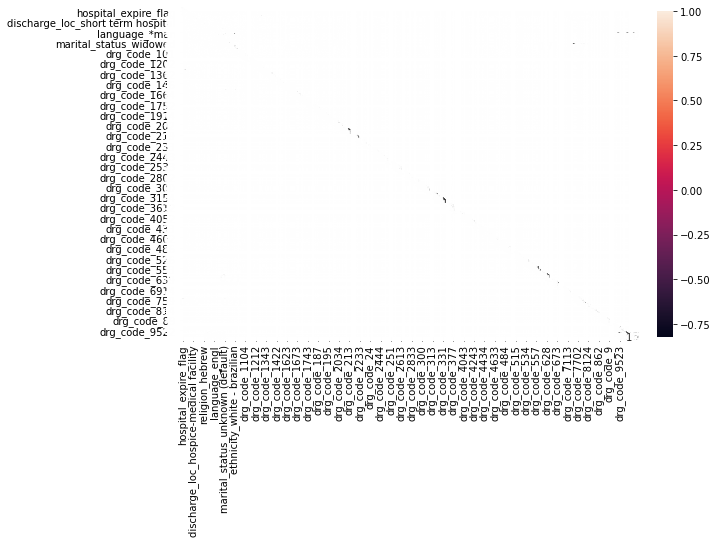

In [30]:
import seaborn as sns

# correlation matrix
cor = df.corr()

# plotting heatmap
plt.figure(figsize = (10,6))
sns.heatmap(cor, annot=True)

In [ ]:
# only keep important features based on univarite analysis

### High correlation filter

This dimensionality reduction algorithm tries to discard inputs that are very similar to others. In simple words, if your opinion is same as your boss, one of you is not required. If the value of two input parameters is always the same, it means they represent the same entity. Then we do not need two parameters there. Just one should be enough.

In technical words, if there is a very high correlation between two input variables, we can safely drop one of them.

In [ ]:
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

print("Top Absolute Correlations")
print(get_top_abs_correlations(df, 10))

### PCA

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 100)
X_pca = pca.fit_transform(X)
# X_train_norm_pca = pca.fit_transform(X_train_norm)
# X_test_norm_pca = pca.transform(X_test_norm)
# X_train_stand_pca = pca.fit_transform(X_train_stand)
# X_test_stand_pca = pca.transform(X_test_stand)

## Splitting the dataset into the Training set and Test set¶

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

## Classifier Algorithms

In [ ]:
# Logistic Regression
model = LogisticRegression(random_state=0)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print('F1 score Raw:', f1_score(y_test, y_pred))
print('Recall score Raw:', recall_score(y_test, y_pred))
print('Accuracy score Raw:', accuracy_score(y_test, y_pred))
print('\n')

model.fit(X_train_norm, y_train)
y_pred = model.predict(X_test_norm)
print('F1 for Normalized:', f1_score(y_test, y_pred))
print('Recall for Normalized:', recall_score(y_test, y_pred))
print('Accuracy score Normalized:', accuracy_score(y_test, y_pred))
print('\n')

model.fit(X_train_stand, y_train)
y_pred = model.predict(X_test_stand)
print('F1 for Standardized:', f1_score(y_test, y_pred))
print('Recall for Standardized:', recall_score(y_test, y_pred))
print('Accuracy score Standardized:', accuracy_score(y_test, y_pred))
print('\n')

model.fit(X_train_norm_pca, y_train)
y_pred = model.predict(X_test_norm_pca)
print('F1 for PCA Normalized:', f1_score(y_test, y_pred))
print('Recall for PCA Normalized:', recall_score(y_test, y_pred))
print('Accuracy score for PCA Normalized:', accuracy_score(y_test, y_pred))
print('\n')

model.fit(X_train_stand_pca, y_train)
y_pred = model.predict(X_test_stand_pca)
print('F1 for PCA Standardized:', f1_score(y_test, y_pred))
print('Recall for PCA Standardized:', recall_score(y_test, y_pred))
print('Accuracy score for PCA Standardized:', accuracy_score(y_test, y_pred))
print('\n')

In [ ]:
# KNN
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier()

grid={"n_neighbors":range(2,10)}
model_cv=GridSearchCV(model,grid,cv=5)
model_cv.fit(X_train,y_train)
y_pred = model_cv.predict(X_test)
print("Best parameters: ", model_cv.best_params_)

In [ ]:
model = KNeighborsClassifier(n_neighbors=6)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print('F1 score Raw:', f1_score(y_test, y_pred))
print('Recall score Raw:', recall_score(y_test, y_pred))
print('Accuracy score Raw:', accuracy_score(y_test, y_pred))
print('\n')

model.fit(X_train_norm, y_train)
y_pred = model.predict(X_test_norm)
print('F1 for Normalized:', f1_score(y_test, y_pred))
print('Recall for Normalized:', recall_score(y_test, y_pred))
print('Accuracy score Normalized:', accuracy_score(y_test, y_pred))
print('\n')

model.fit(X_train_stand, y_train)
y_pred = model.predict(X_test_stand)
print('F1 for Standardized:', f1_score(y_test, y_pred))
print('Recall for Standardized:', recall_score(y_test, y_pred))
print('Accuracy score Standardized:', accuracy_score(y_test, y_pred))
print('\n')

model.fit(X_train_norm_pca, y_train)
y_pred = model.predict(X_test_norm_pca)
print('F1 for PCA Normalized:', f1_score(y_test, y_pred))
print('Recall for PCA Normalized:', recall_score(y_test, y_pred))
print('Accuracy score for PCA Normalized:', accuracy_score(y_test, y_pred))
print('\n')

model.fit(X_train_stand_pca, y_train)
y_pred = model.predict(X_test_stand_pca)
print('F1 for PCA Standardized:', f1_score(y_test, y_pred))
print('Recall for PCA Standardized:', recall_score(y_test, y_pred))
print('Accuracy score for PCA Standardized:', accuracy_score(y_test, y_pred))
print('\n')

In [ ]:
# Support Vector Machine
# Assumption: observations are linear
from sklearn.svm import SVC
model = SVC()

grid={'C':[1,10,100,1000],'gamma':[1,0.1,0.001,0.0001], 'kernel':['linear','rbf', 'sigmoid','poly'],'degree': [2,3,5,7]}
model_cv=GridSearchCV(model,grid,cv=5)
model_cv.fit(X_train,y_train)
y_pred = model_cv.predict(X_test)
print("Best parameters: ", model_cv.best_params_)

In [ ]:
model = SVC(C=1, degree=2, gamma=0.1, kernel='rbf')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print('F1 score Raw:', f1_score(y_test, y_pred))
print('Recall score Raw:', recall_score(y_test, y_pred))
print('Accuracy score Raw:', accuracy_score(y_test, y_pred))
print('\n')

model.fit(X_train_norm, y_train)
y_pred = model.predict(X_test_norm)
print('F1 for Normalized:', f1_score(y_test, y_pred))
print('Recall for Normalized:', recall_score(y_test, y_pred))
print('Accuracy score Normalized:', accuracy_score(y_test, y_pred))
print('\n')

model.fit(X_train_stand, y_train)
y_pred = model.predict(X_test_stand)
print('F1 for Standardized:', f1_score(y_test, y_pred))
print('Recall for Standardized:', recall_score(y_test, y_pred))
print('Accuracy score Standardized:', accuracy_score(y_test, y_pred))
print('\n')

model.fit(X_train_norm_pca, y_train)
y_pred = model.predict(X_test_norm_pca)
print('F1 for PCA Normalized:', f1_score(y_test, y_pred))
print('Recall for PCA Normalized:', recall_score(y_test, y_pred))
print('Accuracy score for PCA Normalized:', accuracy_score(y_test, y_pred))
print('\n')

model.fit(X_train_stand_pca, y_train)
y_pred = model.predict(X_test_stand_pca)
print('F1 for PCA Standardized:', f1_score(y_test, y_pred))
print('Recall for PCA Standardized:', recall_score(y_test, y_pred))
print('Accuracy score for PCA Standardized:', accuracy_score(y_test, y_pred))
print('\n')

In [ ]:
# Naive Bayes
# Advantages: This algorithm requires a small amount of training data to estimate the necessary parameters. 
# Naive Bayes classifiers are extremely fast compared to more sophisticated methods.

# Disadvantages: Naive Bayes is is known to be a bad estimator.

from sklearn.naive_bayes import GaussianNB
model = GaussianNB()

grid={'var_smoothing':[1e-11, 1e-10, 1e-9, 1e-8]}
model_cv=GridSearchCV(model,grid,cv=5)
model_cv.fit(X_train,y_train)
y_pred = model_cv.predict(X_test)
print("Best parameters: ", model_cv.best_params_)

In [ ]:
model = GaussianNB(var_smoothing=1e-11)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print('F1 score Raw:', f1_score(y_test, y_pred))
print('Recall score Raw:', recall_score(y_test, y_pred))
print('Accuracy score Raw:', accuracy_score(y_test, y_pred))
print('\n')

model.fit(X_train_norm, y_train)
y_pred = model.predict(X_test_norm)
print('F1 for Normalized:', f1_score(y_test, y_pred))
print('Recall for Normalized:', recall_score(y_test, y_pred))
print('Accuracy score Normalized:', accuracy_score(y_test, y_pred))
print('\n')

model.fit(X_train_stand, y_train)
y_pred = model.predict(X_test_stand)
print('F1 for Standardized:', f1_score(y_test, y_pred))
print('Recall for Standardized:', recall_score(y_test, y_pred))
print('Accuracy score Standardized:', accuracy_score(y_test, y_pred))
print('\n')

model.fit(X_train_norm_pca, y_train)
y_pred = model.predict(X_test_norm_pca)
print('F1 for PCA Normalized:', f1_score(y_test, y_pred))
print('Recall for PCA Normalized:', recall_score(y_test, y_pred))
print('Accuracy score for PCA Normalized:', accuracy_score(y_test, y_pred))
print('\n')

model.fit(X_train_stand_pca, y_train)
y_pred = model.predict(X_test_stand_pca)
print('F1 for PCA Standardized:', f1_score(y_test, y_pred))
print('Recall for PCA Standardized:', recall_score(y_test, y_pred))
print('Accuracy score for PCA Standardized:', accuracy_score(y_test, y_pred))
print('\n')

In [ ]:
# Decision Tree
# Advantages: Decision Tree is simple to understand and visualise, requires little data preparation, and can handle both numerical and categorical data.
# Disadvantages: Decision tree can create complex trees that do not generalise well, and decision trees can be unstable because small variations in the data might result in a completely different tree being generated.
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier()

grid={"splitter":['best', 'random'], "max_depth":[5,10,15,20], "min_samples_split": [5,10,15,20], "max_features":['auto', 'sqrt', 'log2']}
model_cv=GridSearchCV(model,grid,cv=5)
model_cv.fit(X_train,y_train)
y_pred = model_cv.predict(X_test)
print("Best parameters: ", model_cv.best_params_)

In [ ]:
model = DecisionTreeClassifier(max_depth=5, max_features='log2', min_samples_split=20, splitter='best')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print('F1 score Raw:', f1_score(y_test, y_pred))
print('Recall score Raw:', recall_score(y_test, y_pred))
print('Accuracy score Raw:', accuracy_score(y_test, y_pred))
print('\n')

model.fit(X_train_norm, y_train)
y_pred = model.predict(X_test_norm)
print('F1 for Normalized:', f1_score(y_test, y_pred))
print('Recall for Normalized:', recall_score(y_test, y_pred))
print('Accuracy score Normalized:', accuracy_score(y_test, y_pred))
print('\n')

model.fit(X_train_stand, y_train)
y_pred = model.predict(X_test_stand)
print('F1 for Standardized:', f1_score(y_test, y_pred))
print('Recall for Standardized:', recall_score(y_test, y_pred))
print('Accuracy score Standardized:', accuracy_score(y_test, y_pred))
print('\n')

model.fit(X_train_norm_pca, y_train)
y_pred = model.predict(X_test_norm_pca)
print('F1 for PCA Normalized:', f1_score(y_test, y_pred))
print('Recall for PCA Normalized:', recall_score(y_test, y_pred))
print('Accuracy score for PCA Normalized:', accuracy_score(y_test, y_pred))
print('\n')

model.fit(X_train_stand_pca, y_train)
y_pred = model.predict(X_test_stand_pca)
print('F1 for PCA Standardized:', f1_score(y_test, y_pred))
print('Recall for PCA Standardized:', recall_score(y_test, y_pred))
print('Accuracy score for PCA Standardized:', accuracy_score(y_test, y_pred))
print('\n')

In [ ]:
# Random Forest 
# Ensemble Learning : using different machine algorithms

# The algorithm does not work well for datasets having a lot of outliers, something which needs addressing prior to the model building.

# Advantages: Reduction in over-fitting and random forest classifier is more accurate than decision trees in most cases.

# Disadvantages: Slow real time prediction, difficult to implement, and complex algorithm.

# Build on top of Decision Trees

from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier()

grid={'bootstrap': [True, False],
     'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
     'max_features': ['auto', 'sqrt','log2'],
     'min_samples_split': [5,10,15,20],
     'n_estimators': [10, 20, 40, 60, 80, 100]}
model_cv=GridSearchCV(model,grid,cv=5)
model_cv.fit(X_train,y_train)
y_pred = model_cv.predict(X_test)
print("Best parameters: ", model_cv.best_params_)

In [ ]:
model = RandomForestClassifier(bootstrap=False, max_depth=80, max_features='log2', min_samples_split=5, n_estimators=10)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print('F1 score Raw:', f1_score(y_test, y_pred))
print('Recall score Raw:', recall_score(y_test, y_pred))
print('Accuracy score Raw:', accuracy_score(y_test, y_pred))
feat_importances = pd.Series(model.feature_importances_, index=X_train.columns)
feat_importances.nlargest(20).plot(kind='barh')
plt.show()

model.fit(X_train_norm, y_train)
y_pred = model.predict(X_test_norm)
print('F1 for Normalized:', f1_score(y_test, y_pred))
print('Recall for Normalized:', recall_score(y_test, y_pred))
print('Accuracy score Normalized:', accuracy_score(y_test, y_pred))
feat_importances = pd.Series(model.feature_importances_, index=X_train.columns)
feat_importances.nlargest(20).plot(kind='barh')
plt.show()

model.fit(X_train_stand, y_train)
y_pred = model.predict(X_test_stand)
print('F1 for Standardized:', f1_score(y_test, y_pred))
print('Recall for Standardized:', recall_score(y_test, y_pred))
print('Accuracy score Standardized:', accuracy_score(y_test, y_pred))
feat_importances = pd.Series(model.feature_importances_, index=X_train.columns)
feat_importances.nlargest(20).plot(kind='barh')
plt.show()

model.fit(X_train_norm_pca, y_train)
y_pred = model.predict(X_test_norm_pca)
print('F1 for PCA Normalized:', f1_score(y_test, y_pred))
print('Recall for PCA Normalized:', recall_score(y_test, y_pred))
print('Accuracy score for PCA Normalized:', accuracy_score(y_test, y_pred))
print('\n')

model.fit(X_train_stand_pca, y_train)
y_pred = model.predict(X_test_stand_pca)
print('F1 for PCA Standardized:', f1_score(y_test, y_pred))
print('Recall for PCA Standardized:', recall_score(y_test, y_pred))
print('Accuracy score for PCA Standardized:', accuracy_score(y_test, y_pred))


In [ ]:
#XGBoost
model = xgb.XGBClassifier()

grid={'max_depth': [3, 5, 6, 10, 15, 20],
      'learning_rate': [0.01, 0.1, 0.2, 0.3],
      'subsample': np.arange(0.5, 1.0, 0.1),
      'colsample_bytree': np.arange(0.4, 1.0, 0.1),
      'colsample_bylevel': np.arange(0.4, 1.0, 0.1),
      'n_estimators': [10, 50, 100, 150, 200, 500, 1000]}
model_cv=GridSearchCV(model,grid,cv=5)
model_cv.fit(X_train,y_train)
y_pred = model_cv.predict(X_test)
print("Best parameters: ", model_cv.best_params_)

In [ ]:
def get_xgb_imp(xgb, feat_names):
    from numpy import array
    imp_vals = xgb.booster().get_fscore()
    imp_dict = {feat_names[i]:float(imp_vals.get('f'+str(i),0.)) for i in range(len(feat_names))}
    total = array(imp_dict.values()).sum()
    return {k:v/total for k,v in imp_dict.items()}

In [ ]:
model = xgb.XGBClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print('F1 score Raw:', f1_score(y_test, y_pred))
print('Recall score Raw:', recall_score(y_test, y_pred))
print('Accuracy score Raw:', accuracy_score(y_test, y_pred))
get_xgb_imp(model,feat_names)

model.fit(X_train_norm, y_train)
y_pred = model.predict(X_test_norm)
print('F1 for Normalized:', f1_score(y_test, y_pred))
print('Recall for Normalized:', recall_score(y_test, y_pred))
print('Accuracy score Normalized:', accuracy_score(y_test, y_pred))
get_xgb_imp(model,feat_names)

model.fit(X_train_stand, y_train)
y_pred = model.predict(X_test_stand)
print('F1 for Standardized:', f1_score(y_test, y_pred))
print('Recall for Standardized:', recall_score(y_test, y_pred))
print('Accuracy score Standardized:', accuracy_score(y_test, y_pred))
get_xgb_imp(model,feat_names)

model.fit(X_train_norm_pca, y_train)
y_pred = model.predict(X_test_norm_pca)
print('F1 for PCA Normalized:', f1_score(y_test, y_pred))
print('Recall for PCA Normalized:', recall_score(y_test, y_pred))
print('Accuracy score for PCA Normalized:', accuracy_score(y_test, y_pred))
print('\n')

model.fit(X_train_stand_pca, y_train)
y_pred = model.predict(X_test_stand_pca)
print('F1 for PCA Standardized:', f1_score(y_test, y_pred))
print('Recall for PCA Standardized:', recall_score(y_test, y_pred))
print('Accuracy score for PCA Standardized:', accuracy_score(y_test, y_pred))